In [2]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_CLIENT_NAME`
* `SH_CLIENT_SECRET`
* `SH_INSTANCE_ID`
* `SH_CLIENT_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `REFERENCE_DATA`
* `AWS_BUCKET`
* `OGC_EDC_URL`
* `DB_HOST`
* `DB_NAME`
* `DB_USER`
* `DB_PASSWORD`
------


## Important notes
This notebook requires:
- POSTGIS database (with access information exposed as environment variables) having sample LPIS data ingested -> please find further information [here](https://github.com/eurodatacube/notebooks/tree/master/artifacts)

## LPIS Use case: Crop-type classification (AUT)

This notebook demonstrates how Euro Data Cube (EDC) tools can be utilized for exploratory analysis and manipulation of data in Land Parcel Identification System (LPIS). The most important part is the example of using satellite imagery and machine learning algorithms for crop type classification, which should be a valuable support for decisions related with LPIS controls.
The described workflow consists of several parts:

1. Prepare and explore LPIS data and satellite imagery
2. Run Machine Learning and create a model for crop type classification
3. Visualize results and extract information to support LPIS controls
4. Classify on parcel level per LPIS ID
5. Persist results in database

In [3]:
# This notebook uses the EO-Learn ML library which requires configuration passed via the 'sentinel.config' tool
!sentinelhub.config --sh_base_url 'https://services.sentinel-hub.com'
!sentinelhub.config --sh_client_id $SH_CLIENT_ID
!sentinelhub.config --sh_client_secret $SH_CLIENT_SECRET
!sentinelhub.config --instance_id $SH_INSTANCE_ID

In [4]:
# see section Important Notes above
import os
db_conn_params = {
    'host': os.getenv('DB_HOST'),
    'database': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD')
}

### Import packages

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import datetime
import time
import itertools
import math
import subprocess
import fiona
import fiona.crs
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm

# Machine learning 
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor
from eolearn.core.core_tasks import AddFeature
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam, UtmGridSplitter

# OAuth2
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# DB and raw geometry
import psycopg2
from psycopg2._psycopg import AsIs
from psycopg2.extensions import register_adapter
import shapely.wkt
from shapely.geometry import Polygon, MultiPolygon
from geopandas import GeoDataFrame


# imports for xcube
import xarray as xr
from shapely.ops import cascaded_union

from xcube_sh.cube import open_cube
from xcube_sh.observers import Observers
from xcube_sh.config import CubeConfig

from xcube.core.geom import mask_dataset_by_geometry

# Amazon S3
import boto3

/opt/conda/lib/python3.7/site-packages/xcube_sh/cube.py:22: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable
/opt/conda/lib/python3.7/site-packages/xcube_sh/store.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping


## Database loading and mapping functionality

In [6]:
## mapping of crop type groups into 24 classes that are to be predicted

# AT: vector to raster needs uint8 values 
ctToctnuml4aMapping = {
    1: [1010], #SOMMERGETREIDE
    2: [1020], #WINTERGETREIDE
    3: [1030], #MENGGETREIDE_AEHNLICHES
    4: [1040], #MAIS_AEHNLICHES
    5: [1050], #SOMMERRAPS_AEHNLICHES
    6: [1060], #WINTERRAPS_AEHNLICHES
    7: [1070], #SONNENBLUME
    8: [1080], #HANF
    9: [1090], #LEGUMINOSEN_AEHNLICHES
    10: [1100], #WINTERLEGUMINOSE
    11: [1110], #KARTOFFELN_AEHNLICHES
    12: [1120], #RUEBEN
    13: [1130], #GEMUESE_AEHNLICHES
    14: [1140], #GEWUERZE_AEHNLICHES
    15: [1150], #WINTERGEWUERZE_AEHNLICHES   
    16: [1160], #KUERBIS
    17: [1170], #BRACHE
    18: [1180], #DAUERKULTUR
    19: [1190], #GEWAECHSHAUS
    20: [1200], #WEIN
    21: [1210], #GRUENLAND
    22: [1220], #PRO_RATA
    23: [1230], #LAGERFLAECHEN
    24: [1240] #SONSTIGES
}
ctnuml4aToctMapping = {ctnuml4a: ctid for ctid, ctnuml4aList in ctToctnuml4aMapping.items() for ctnuml4a in ctnuml4aList}

# needed for DB mapping
register_adapter(np.int64, AsIs)
register_adapter(Polygon, AsIs)
register_adapter(MultiPolygon, AsIs)

def loadFromDatabase(db_conn, taskName, tableName, bbox, dateFilterMin, dateFilterMax, mappedColumnName = None, mappingLambdaFunc = None):
    columns = ["ogd_id", "ctnuml4a", "geometry"]
    geometries = []

    if (mappedColumnName and mappingLambdaFunc):
        columns.append(mappedColumnName)
    
    with db_conn.cursor() as cur:
        sql = '''
            SELECT ogd_id, ctnuml4a, ST_AsText(ST_Transform(geometry, {targetCrs})) 
            FROM {tableName}
            WHERE ST_Intersects(geometry, ST_Transform(ST_GeomFromText('{bbox}', {targetCrs}), 31287))
                AND ref_date >= '{dateFilterMin}' AND ref_date <= '{dateFilterMax}'
            '''
        
        sql = sql.format(tableName = tableName, targetCrs = bbox.crs.value, 
            dateFilterMin = dateFilterMin, dateFilterMax = dateFilterMax,
            bbox = bbox.geometry.wkt)
        #print(sql)

        cur.execute(sql)
        for row in cur:
            properties = {"ogd_id": row[0], "ctnuml4a_id": row[1]}
            if (mappedColumnName and mappingLambdaFunc):
                properties[mappedColumnName] = mappingLambdaFunc(row[1])

            geometry = shapely.wkt.loads(row[2]);
            geometries.append({"geometry": geometry, "properties": properties})
        print(taskName + ": " + str(len(geometries)) + ' DB records for bbox = ' + str(bbox) + ' ' + str(bbox.crs.value))        
        crs = {"init": "epsg:{}".format(bbox.crs.value)}
        gdf = GeoDataFrame.from_features(geometries, crs = crs, columns = columns)
        return gdf

## Part 1: Exploratory Analysis

### Define the Area-of-Interest (AOI):

The whole territory of a country is splited into patches which makes the processing more efficient. The process is run on are of 3x3 patches for demonstration purposes.  AOI can be selected as the id of the patch in the middle.

Main steps in this part of the notebook:
* Load a geographical shape of Austria
* Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)
* Split it into smaller, manageable, non-overlapping rectangular tiles (patches)
* Select a small 3x3 area for classification

Be sure that your choice of CRS is the same as the CRS of your reference data.

In the case that you are having problems with empty data being downloaded, try changing the CRS to something that suits the location of the AOI better.

In [7]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join('example_data')

# Load geojson file containing the outline of the country
country = gpd.read_file(os.path.join(DATA_FOLDER, 'at_not_buffered.geojson'))

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values[-1]

# Define bounds and select middle patch ID
use_smaller_patches = True

ID = 13311 if use_smaller_patches else 1606

bounds = [15.5242, 48.7574, 15.5391, 48.7698]  if use_smaller_patches else [15.4191, 48.653, 15.7335, 48.8102]

bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25 * 9, 17 * 9))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large
bbox_list_aligned = [BBox((10 * math.floor(bbox.min_x / 10), 10 * math.floor(bbox.min_y / 10), 
                           10 * math.floor(bbox.max_x / 10), 10 * math.floor(bbox.max_y / 10)), country_crs) 
                     for bbox in bbox_splitter.get_bbox_list()]

bbox_list = np.array(bbox_list_aligned)
info_list = np.array(bbox_splitter.get_info_list())

all_patches_gdf = gpd.GeoDataFrame(
    {
        "index_x": [info['index_x'] for info in info_list],
        "index_y": [info['index_y'] for info in info_list],
    },
    crs={'init': CRS.ogc_string(country_crs)},
    geometry=[Polygon(bbox.get_polygon()) for bbox in bbox_list]
)

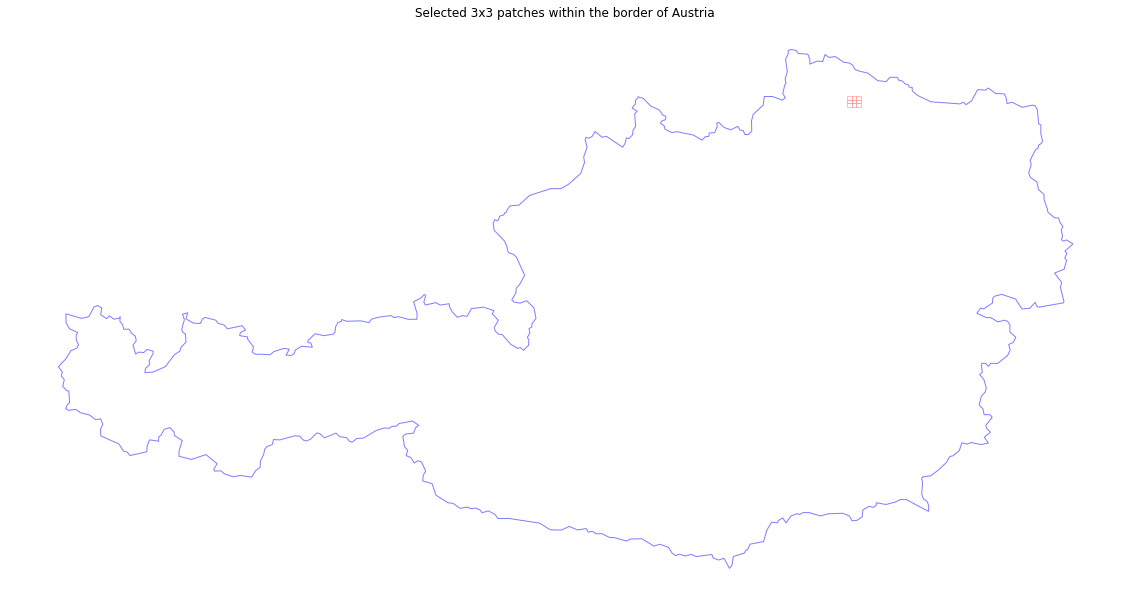

In [8]:
# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = './selected_3x3_bboxes_at_small.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_at_large.shp'
gdf.to_file(shapefile_name)

# Visualize the selection
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20));
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5);
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5);
ax.set_title('Selected 3x3 patches within the border of Austria');
plt.axis('off');

In [9]:
# Rearange selected EOPatches into bbox, which can be used for xcube definition
patches_geometries = [Polygon(bbox.transform(CRS.WGS84).get_polygon()) for bbox in bbox_list[patchIDs]]
bbox_of_patches = gpd.GeoSeries(cascaded_union(patches_geometries))

x1 = bbox_of_patches.bounds['minx'][0].item()
y1 = bbox_of_patches.bounds['miny'][0].item()
x2 = bbox_of_patches.bounds['maxx'][0].item()
y2 = bbox_of_patches.bounds['maxy'][0].item()
bbox_wgs84 = x1, y1, x2, y2

In [10]:
## Plot time series of satellite images for bbox
x1, y1, x2, y2 = bbox
spatial_res_meters = 10
pixx = (x2-x1)/spatial_res_meters; pixy = (y2-y1)/spatial_res_meters;
x1, y1, x2, y2 = bbox_wgs84
spatial_res = float(np.mean([(x2-x1)/pixx, (y2-y1)/pixy]))

cube_config = CubeConfig(dataset_name='S2L1C',
                         band_names=["B02", "B03", "B04", "B08", "B11", "B12"],
                         chunk_size=[512, 512],
                         geometry=bbox_wgs84,
                         spatial_res=spatial_res,
                         time_range=['2018-01-01', '2018-09-30'],
                         time_period='4D')  

# So we can print some SentinelHub usage stats
request_collector = Observers.request_collector()
cube = open_cube(cube_config, request_collector)

# Add Indecies
## NDVI
b_red = cube.B04
b_nir = cube.B08
ndvi = (b_nir - b_red) / (b_nir + b_red)
ndvi.attrs['long_name'] = 'Normalized Difference Vegetation Index'
ndvi.attrs['units'] = 'unitless'
cube["ndvi"] = ndvi

## NDWI
b_green = cube.B03
b_nir = cube.B08
ndwi = (b_green - b_nir) / (b_green + b_nir)
ndwi.attrs['long_name'] = 'Normalized Difference Water Index'
ndwi.attrs['units'] = 'unitless'
cube["ndwi"] = ndwi

cube.time

/opt/conda/lib/python3.7/site-packages/xcube_sh/store.py:73: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  t_array = np.array([s + 0.5 * (e - s) for s, e in self._time_ranges]).astype('datetime64[s]').astype(np.int64)
/opt/conda/lib/python3.7/site-packages/xcube_sh/store.py:74: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  t_bnds_array = np.array(self._time_ranges).astype('datetime64[s]').astype(np.int64)


<xarray.DataArray 'time' (time: 69)>
array(['2018-01-03T00:00:00.000000000', '2018-01-07T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-15T00:00:00.000000000',
       '2018-01-19T00:00:00.000000000', '2018-01-23T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-02-04T00:00:00.000000000', '2018-02-08T00:00:00.000000000',
       '2018-02-12T00:00:00.000000000', '2018-02-16T00:00:00.000000000',
       '2018-02-20T00:00:00.000000000', '2018-02-24T00:00:00.000000000',
       '2018-02-28T00:00:00.000000000', '2018-03-04T00:00:00.000000000',
       '2018-03-08T00:00:00.000000000', '2018-03-12T00:00:00.000000000',
       '2018-03-16T00:00:00.000000000', '2018-03-20T00:00:00.000000000',
       '2018-03-24T00:00:00.000000000', '2018-03-28T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-04-05T00:00:00.000000000',
       '2018-04-09T00:00:00.000000000', '2018-04-13T00:00:00.000000000',
       '2018-04-17T00:00:00.000000000', '2018-04-21T00:00:00.000000000',
       '2018-04-25T00:00:00.000000000', '2018-04-29T00:00:00.000000000',
       '2018-05-03T00:00:00.000000000', '2018-05-07T00:00:00.000000000',
       '2018-05-11T00:00:00.000000000', '2018-05-15T00:00:00.000000000',
       '2018-05-19T00:00:00.000000000', '2018-05-23T00:00:00.000000000',
       '2018-05-27T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
       '2018-06-04T00:00:00.000000000', '2018-06-08T00:00:00.000000000',
       '2018-06-12T00:00:00.000000000', '2018-06-16T00:00:00.000000000',
       '2018-06-20T00:00:00.000000000', '2018-06-24T00:00:00.000000000',
       '2018-06-28T00:00:00.000000000', '2018-07-02T00:00:00.000000000',
       '2018-07-06T00:00:00.000000000', '2018-07-10T00:00:00.000000000',
       '2018-07-14T00:00:00.000000000', '2018-07-18T00:00:00.000000000',
       '2018-07-22T00:00:00.000000000', '2018-07-26T00:00:00.000000000',
       '2018-07-30T00:00:00.000000000', '2018-08-03T00:00:00.000000000',
       '2018-08-07T00:00:00.000000000', '2018-08-11T00:00:00.000000000',
       '2018-08-15T00:00:00.000000000', '2018-08-19T00:00:00.000000000',
       '2018-08-23T00:00:00.000000000', '2018-08-27T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-04T00:00:00.000000000',
       '2018-09-08T00:00:00.000000000', '2018-09-12T00:00:00.000000000',
       '2018-09-16T00:00:00.000000000', '2018-09-20T00:00:00.000000000',
       '2018-09-24T00:00:00.000000000', '2018-09-28T00:00:00.000000000',
       '2018-10-02T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03 2018-01-07 ... 2018-10-02
Attributes:
    standard_name:  time
    bounds:         time_bnds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


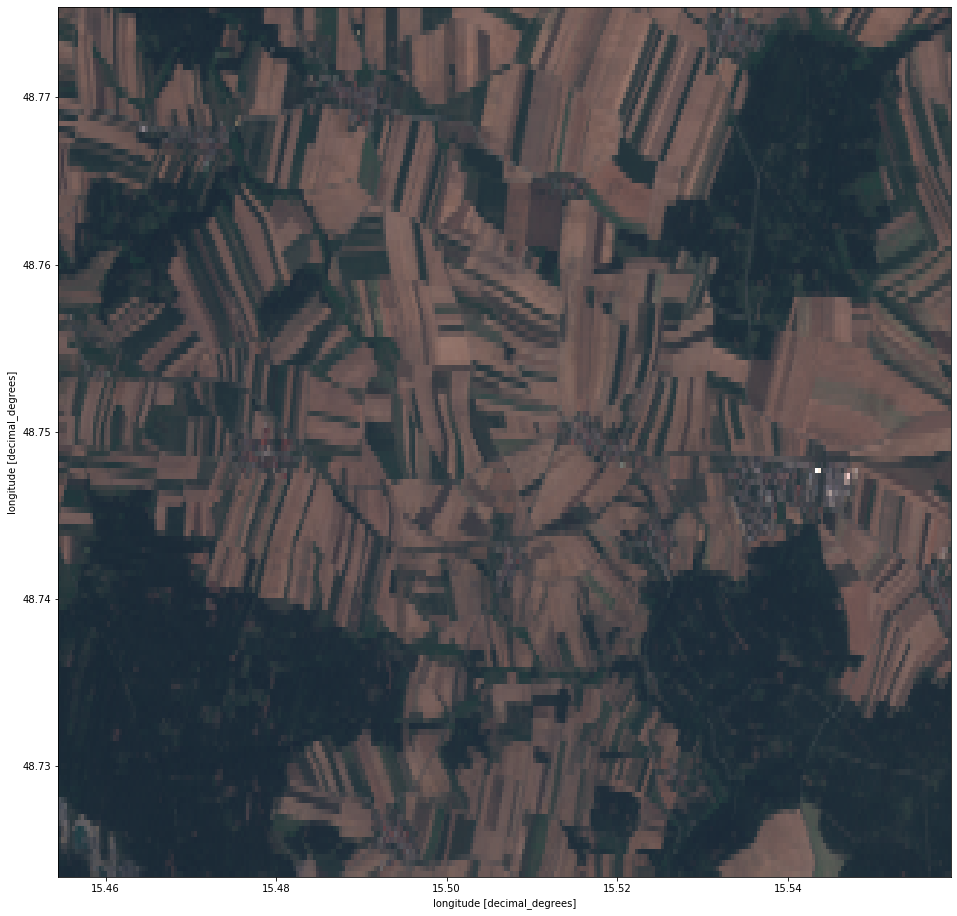

In [11]:
selected_time = '2018-08-03' #User's input. Must be a value in cube.time

# True color image

factor = 2.5
R = cube.B04.sel(time=selected_time)*factor
G = cube.B03.sel(time=selected_time)*factor
B = cube.B02.sel(time=selected_time)*factor
RGB = np.dstack([R, G, B])
rgb_array = xr.DataArray(RGB, dims=('lat', 'lon', 'b'), coords=dict(lat=cube.B04.lat, lon=cube.B04.lon))
rgb_array.plot.imshow(rgb='b', figsize=(16, 16))

## Part 2: Crop Type prediction with Machine Learning

### Set some of the inputs for prediction with ML

In [12]:
selected_date_for_reference_data = '2018-06-30'
selected_date_interval_for_satellite_imagery = ['2018-01-01', '2018-09-30']
selected_max_cc = 0.8

### Fill EOPatches with data:

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

* L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

* SentinelHub's cloud probability map and cloud mask

Additionally, we will add:

* Calculated NDVI, NDWI, euclidean NORM information

* A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:
   
    1. IS_DATA == True
    2. CLOUD_MASK == 0 (1 indicates that pixel was identified to be covered with cloud)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

#### Define some needed custom EOTasks

In [13]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

#### Define the workflow tasks

In [14]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=selected_max_cc # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small' if use_smaller_patches else './eopatches_large'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

#### Reference map task

For this example the LPIS Data from the austrian Open Government Data portal data.gv.at is used: [INVEKOS Schläge Österreich](https://www.data.gv.at/katalog/dataset/e21a731f-9e08-4dd3-b9e5-cd460438a5d9)
The crop types are grouped into 23 groups for classification:

In [15]:
class CTGROUPS(Enum):
    NO_DATA                   = (0, "NO_DATA", "#ffffff")
    SOMMERGETREIDE            = (1, "SOMMERGETREIDE", "#7bf500")
    WINTERGETREIDE            = (2, "WINTERGETREIDE", "#a8ff2b")
    MENGGETREIDE_AEHNLICHES   = (3, "MENGGETREIDE_AEHNLICHES", "#daff1f")
    MAIS_AEHNLICHES           = (4, "MAIS_AEHNLICHES", "#fff200")
    SOMMERRAPS_AEHNLICHES     = (5, "SOMMERRAPS_AEHNLICHES", "#ffd701")
    WINTERRAPS_AEHNLICHES     = (6, "WINTERRAPS_AEHNLICHES", "#ffbc0c")
    SONNENBLUME               = (7, "SONNENBLUME", "#ff7005")
    HANF                      = (8, "HANF", "#ff2a00")
    LEGUMINOSEN_AEHNLICHES    = (9, "LEGUMINOSEN_AEHNLICHES", "#ff0046")
    WINTERLEGUMINOSE          = (10, "WINTERLEGUMINOSE", "#ff00f8")
    KARTOFFELN_AEHNLICHES     = (11, "KARTOFFELN_AEHNLICHES", "#b325ff")
    RUEBEN                    = (12, "RUEBEN", "#cd61f4")
    GEMUESE_AEHNLICHES        = (13, "GEMUESE_AEHNLICHES", "#ef96f1")
    GEWUERZE_AEHNLICHES       = (14, "GEWUERZE_AEHNLICHES", "#f6c9f7")
    WINTERGEWUERZE_AEHNLICHES = (15, "WINTERGEWUERZE_AEHNLICHES", "#000080")
    KUERBIS                   = (16, "KUERBIS", "#004821")
    BRACHE                    = (17, "BRACHE", "#00288a")
    DAUERKULTUR               = (18, "DAUERKULTUR", "#0046ff")
    GEWAECHSHAUS              = (19, "GEWAECHSHAUS", "#00c5ff")
    WEIN                      = (20, "WEIN", "#00f6f8")
    GRUENLAND                 = (21, "GRUENLAND", "#26ef00")
    PRO_RATA                  = (22, "PRO_RATA", "#67d400")
    LAGERFLAECHEN             = (23, "LAGERFLAECHEN", "#aaaaaa")
    SONSTIGES                 = (24, "SONSTIGES", "#555555")

    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3


#Reference colormap things
ct_cmap = mpl.colors.ListedColormap([entry.color for entry in CTGROUPS])
ct_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 24, 1), ct_cmap.N)

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry` package. All polygons belonging to the each of the classes are separately burned to the raster mask.

In [16]:
# user param
LPISRecordsDateMin = selected_date_for_reference_data 
LPISRecordsDateMax = selected_date_for_reference_data

class LoadFromDatabaseTask(EOTask):
    def __init__(self, feature, taskName, crs, tableName, dateFilterMin, dateFilterMax, mappedColumnName = None, mappingLambdaFunc = None):
        self.feature_type, self.feature_name = next(self._parse_features(feature)())
        self.taskName = taskName
        self.crs = crs
        self.tableName = tableName
        self.dateFilterMin = dateFilterMin
        self.dateFilterMax = dateFilterMax
        self.mappedColumnName = mappedColumnName
        self.mappingLambdaFunc = mappingLambdaFunc

    def execute(self, eopatch, db_conn):
        eopatch[self.feature_type][self.feature_name] = loadFromDatabase(db_conn, 
            self.taskName, self.tableName, eopatch.bbox, 
            self.dateFilterMin, self.dateFilterMax, 
            self.mappedColumnName, self.mappingLambdaFunc)
        return eopatch
    

# LPIS
ct_use_db_task = LoadFromDatabaseTask((FeatureType.VECTOR_TIMELESS, 'CROP_TYPE_GDF'), 
    "crop type", CRS.UTM_33N, "lpis_at", LPISRecordsDateMin, LPISRecordsDateMax, 
    "ct", lambda ct_id: ctnuml4aToctMapping[ct_id] if ct_id in ctnuml4aToctMapping else 0)


ct_rasterization_task = VectorToRaster((FeatureType.VECTOR_TIMELESS, 'CROP_TYPE_GDF'), (FeatureType.MASK_TIMELESS, 'CROP_TYPE'),
    values_column='ct', raster_shape=(FeatureType.MASK, 'IS_VALID'),
    raster_dtype=np.uint8)

ct_export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'CROP_TYPE'))

#### Define the workflow

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an `EOWorkflow` which does this for you.

The following workflow is created and executed:

1. Create EOPatches with band data
2. Add cloud info
3. Calculate and add NDVI, NDWI, NORM
4. Add mask of valid pixels
5. Add scalar feature representing the cound of valid pixels
7. Save eopatches

An EOWorkflow can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as `LinearWorkflow`

Define the workflow

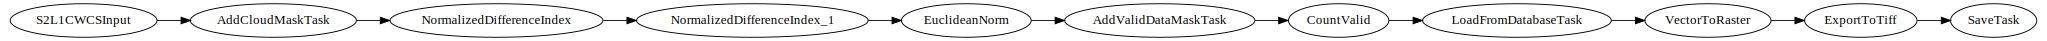

In [17]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    ct_use_db_task,
    ct_rasterization_task,
    ct_export_tiff,
    save
)

# Let's visualize it
workflow.dependency_graph()

_This may take some time, so go grab a cup of coffee ..._

In [18]:
%%time

# Execute the workflow

source_tiff_location = './source_tiff'
if not os.path.isdir(source_tiff_location):
    os.makedirs(source_tiff_location)

# define additional parameters of the workflow
with psycopg2.connect(**db_conn_params) as db_conn: # must use single DB connection for all the tasks
    execution_args = []
    for idx, bbox in enumerate(bbox_list[patchIDs]):       
        execution_args.append({
            add_data: {'bbox': bbox, 'time_interval': selected_date_interval_for_satellite_imagery},
            ct_use_db_task: {'db_conn': db_conn},
            ct_export_tiff: {'filename': '{}/crop_type_eopatch_{}_original.tiff'.format(source_tiff_location, idx)},
            save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
        })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=9, multiprocess=False)

executor.make_report()

crop type: 224 DB records for bbox = 538530.0,5400680.0,541080.0,5402600.0 32633
crop type: 301 DB records for bbox = 538530.0,5398760.0,541080.0,5400680.0 32633
crop type: 384 DB records for bbox = 533420.0,5400680.0,535980.0,5402600.0 32633
crop type: 259 DB records for bbox = 535980.0,5400680.0,538530.0,5402600.0 32633
crop type: 82 DB records for bbox = 533420.0,5396840.0,535980.0,5398760.0 32633
crop type: 500 DB records for bbox = 535980.0,5396840.0,538530.0,5398760.0 32633
crop type: 436 DB records for bbox = 535980.0,5398760.0,538530.0,5400680.0 32633
crop type: 456 DB records for bbox = 533420.0,5398760.0,535980.0,5400680.0 32633
crop type: 137 DB records for bbox = 538530.0,5396840.0,541080.0,5398760.0 32633

CPU times: user 41 s, sys: 9.51 s, total: 50.5 s
Wall time: 46.9 s


In this case, all patches come from a small region, so all of them have the same dates of acquisition for at least a few dates, so we can inspect the area without interpolation at this point.

### Visualize the true color image

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


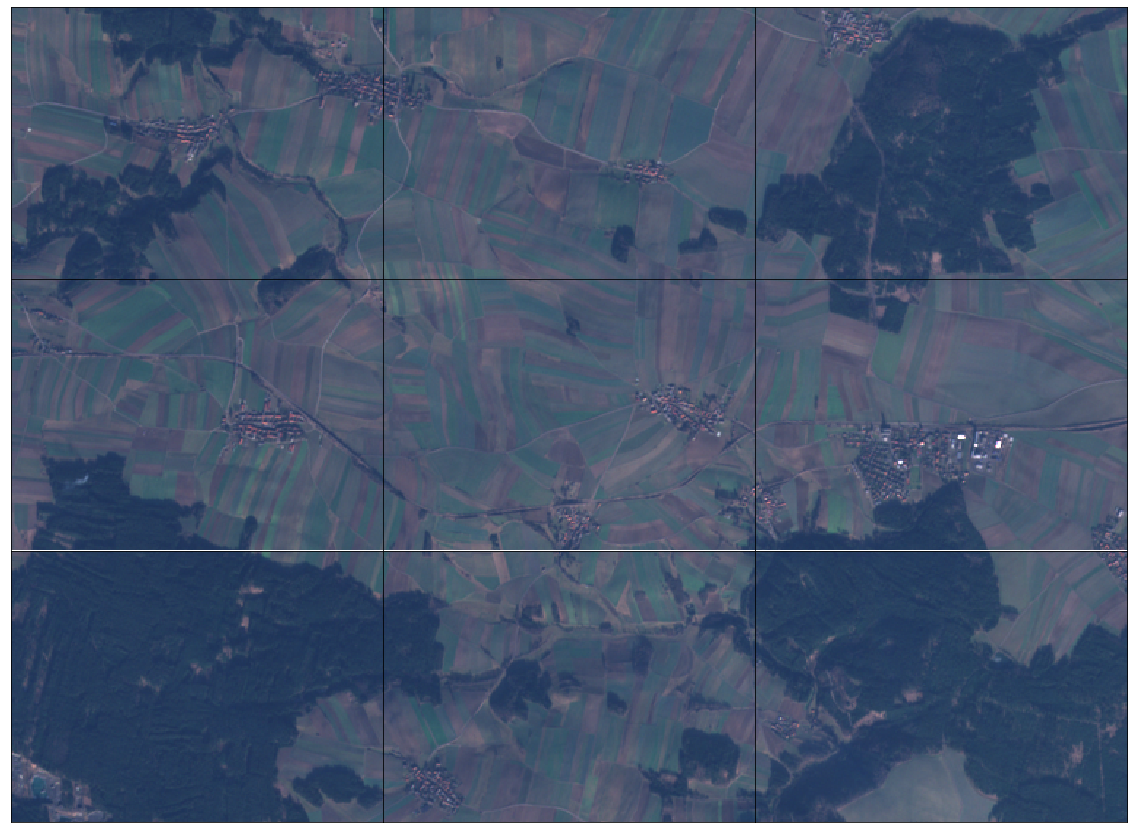

In [19]:
# Draw the RGB image
path_out = './eopatches_small' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.data['BANDS'][0][..., [2, 1, 0]] * 3.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

### Visualize the reference map

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


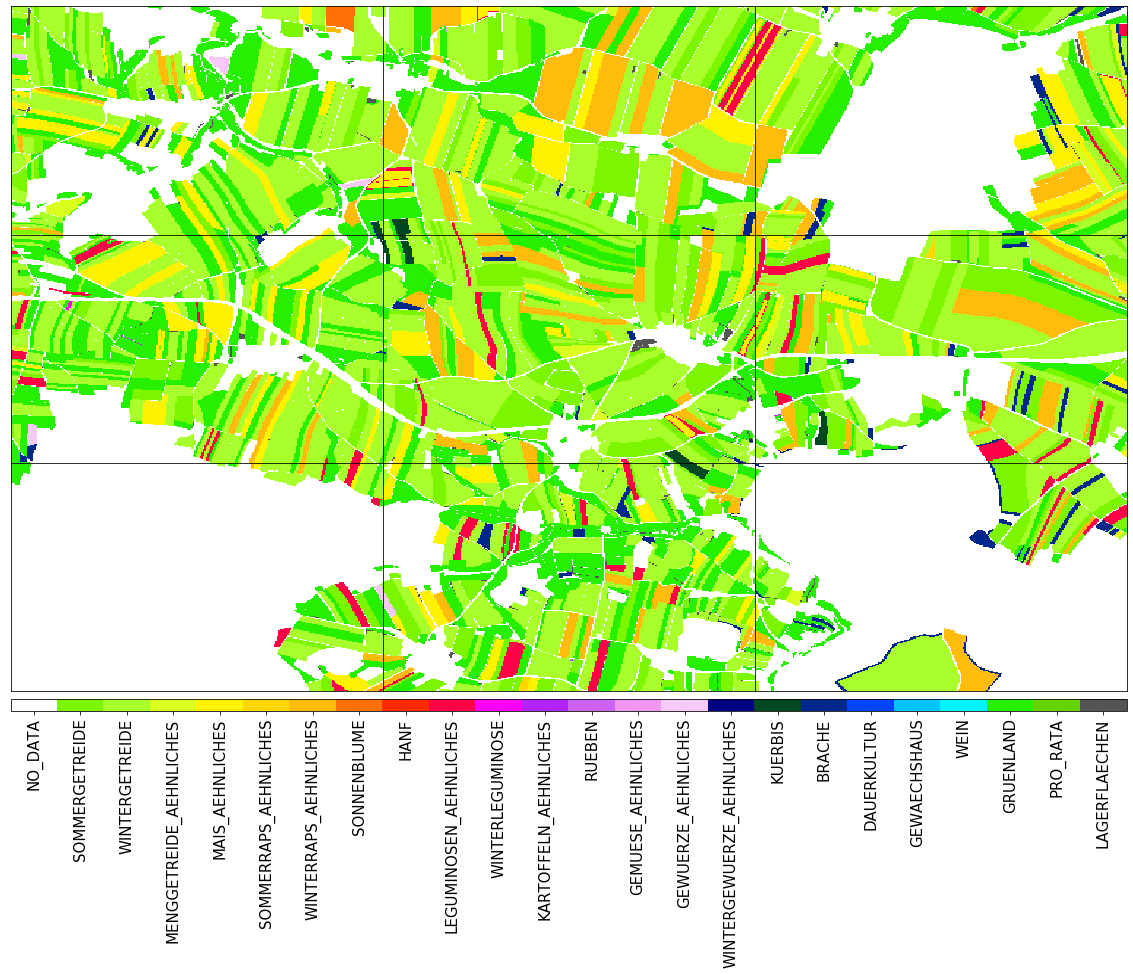

In [20]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['CROP_TYPE'].squeeze(), cmap=ct_cmap, norm=ct_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in CTGROUPS])
cb.ax.set_xticklabels([entry.class_name for entry in CTGROUPS], rotation=90, fontsize=15)
plt.show()

### Prepare the training data

We will create a new workflow that processes the data:

1. Remove too cloudy scenes
   * Check the ratio of the valid data for each patch and for each time frame
   * Keep only time frames with > 80 % valid coverage (no clouds)
2. Concatenate BAND, NDVI, NDWI, NORM info into a single feature called FEATURES
3. Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Create a task for linear interpolation in the temporal dimension
   * Provide the cloud mask to tell the interpolating function which values to update
4. Perform erosion
   * This removes artefacts with a width of 1 px, and also removes the edges between polygons of different classes
5. Random spatial sampling of the EOPatches
   * Randomly take a subset of pixels from a patch to use in the machine learning training
6. Split patches for training/validation
   * Split the patches into a training and validation set

#### Define EOTasks

In [21]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold
    
# TASK TO LOAD EXISTING EOPATCHES
load = LoadTask(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
selected_date_interval_for_interpolation = selected_date_interval_for_satellite_imagery + [16] 
# TODO: replace fixed number of times with fixed time difference
#resampled_range = tuple(selected_date_interval_for_satellite_imagery)
resampled_range = (
    selected_date_interval_for_interpolation[0].replace("-", ""),
    selected_date_interval_for_interpolation[1].replace("-", ""),
    selected_date_interval_for_interpolation[2]
)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'CROP_TYPE')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'CROP_TYPE','CROP_TYPE_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = int(4e4) if use_smaller_patches else int(1e5) # no. of pixels to sample
ref_labels = list(range(11)) # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples, 
    ref_mask_feature='CROP_TYPE_ERODED', 
    ref_labels=ref_labels, 
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'CROP_TYPE_ERODED')
    ])

path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

#### Run the EOWorkflow over all EOPatches

In [22]:
%%time
   
execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': 'eopatch_{}'.format(idx)},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=True)

executor.make_report()



CPU times: user 16.9 s, sys: 3.38 s, total: 20.3 s
Wall time: 56.7 s


### Model construction and training

The patches are split into a train and test subset, where we take the patch with ID = 1 for testing, since it seems a good representative of the area. 

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features, with $f$ the size of bands and band combinations (in this example 9) and $t$ the length of the resampled time-series

[LightGBM](https://github.com/Microsoft/LightGBM) is used as a ML model. It is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for many machine learning tasks.

The default hyper-parameters are used in this example. For more info on parameter tuning, check the [ReadTheDocs](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) of the package.

In [23]:
# load sampled eopatches
eopatches = []
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'

for i in range(9):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True))    

eopatches = np.array(eopatches)

In [24]:
# Definition of the train and test patch IDs
train_ID = [0,2,3,4,5,6,7,8] if use_smaller_patches else [0,1,3,4,5,6,7,8]
test_ID = [1] if use_smaller_patches else [2]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['CROP_TYPE_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['CROP_TYPE_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]

In [25]:
# Set up training classes
labels_unique = np.unique(labels_train)

In [26]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(labels_unique), 
    metric='multi_logloss'
)

# train the model
model.fit(features_train, labels_train)

# uncomment to save the model
model_base_name = 'model_AT_CT_smaller' if use_smaller_patches else 'model_AT_CT_larger'
joblib.dump(model, './{}.pkl'.format(model_base_name))

CPU times: user 2min 44s, sys: 0 ns, total: 2min 44s
Wall time: 1min 6s


['./model_AT_CT_smaller.pkl']

### Validation

Validation of the model is a crucial step in data science. All models are wrong, but some are less wrong than others, so model evaluation is important.

In order to validate the model, we use the training set to predict the classes, and then compare the predicted set of labels to the "ground truth".

Unfortunately, ground truth in the scope of EO is a term that should be taken lightly. Usually, it is not 100 % reliable due to several reasons:

* Labels are determined at specific time, but crop types change.
* Some classes can have an overlap or similar definitions (_part of a continuum, and not discrete distributions_)
* Human error (_mistakes made within the decleration)

The validation is performed by evaluating various metrics, such as accuracy, precision, recall, $F_1$ score, some of which are nicely described [in this blog post](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)

In [27]:
# uncomment to load the model and replace with your file, usually just correct the date
model_path = './model_AT_CT_smaller.pkl' if use_smaller_patches else './model_AT_CT_larger.pkl'
model = joblib.load(model_path)

In [28]:
# predict the test labels
plabels_test = model.predict(features_test)

Get the overall accuracy (OA) and the weighted $F_1$ score

In [29]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 87.8%
Classification F1-score 89.0%


$F_1$ score, precision, and recall for each class separately

In [30]:
class_labels_test = set(np.unique(labels_test))
class_labels_train = set(np.unique(labels_train))
class_labels = list(class_labels_test.union(class_labels_train))
class_names = [entry.class_name for entry in CTGROUPS]

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, ct in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:30s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(ct, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * SOMMERGETREIDE                 = 68.1 |  56.1  | 86.6
         * WINTERGETREIDE                 = 95.2 |  93.8  | 96.6
         * MENGGETREIDE_AEHNLICHES        = 11.8 |  18.7  | 8.7
         * MAIS_AEHNLICHES                = 93.2 |  96.7  | 90.0
         * SOMMERRAPS_AEHNLICHES          = 0.0 |  0.0  | 0.0
         * WINTERRAPS_AEHNLICHES          = 90.1 |  92.6  | 87.7
         * SONNENBLUME                    = 0.0 |  0.0  | 0.0
         * LEGUMINOSEN_AEHNLICHES         = 21.1 |  51.2  | 13.3
         * WINTERLEGUMINOSE               = 0.0 |  0.0  | 0.0


### Plot the standard and transposed Confusion Matrix

In [31]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)

        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes)+1)-0.5
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)

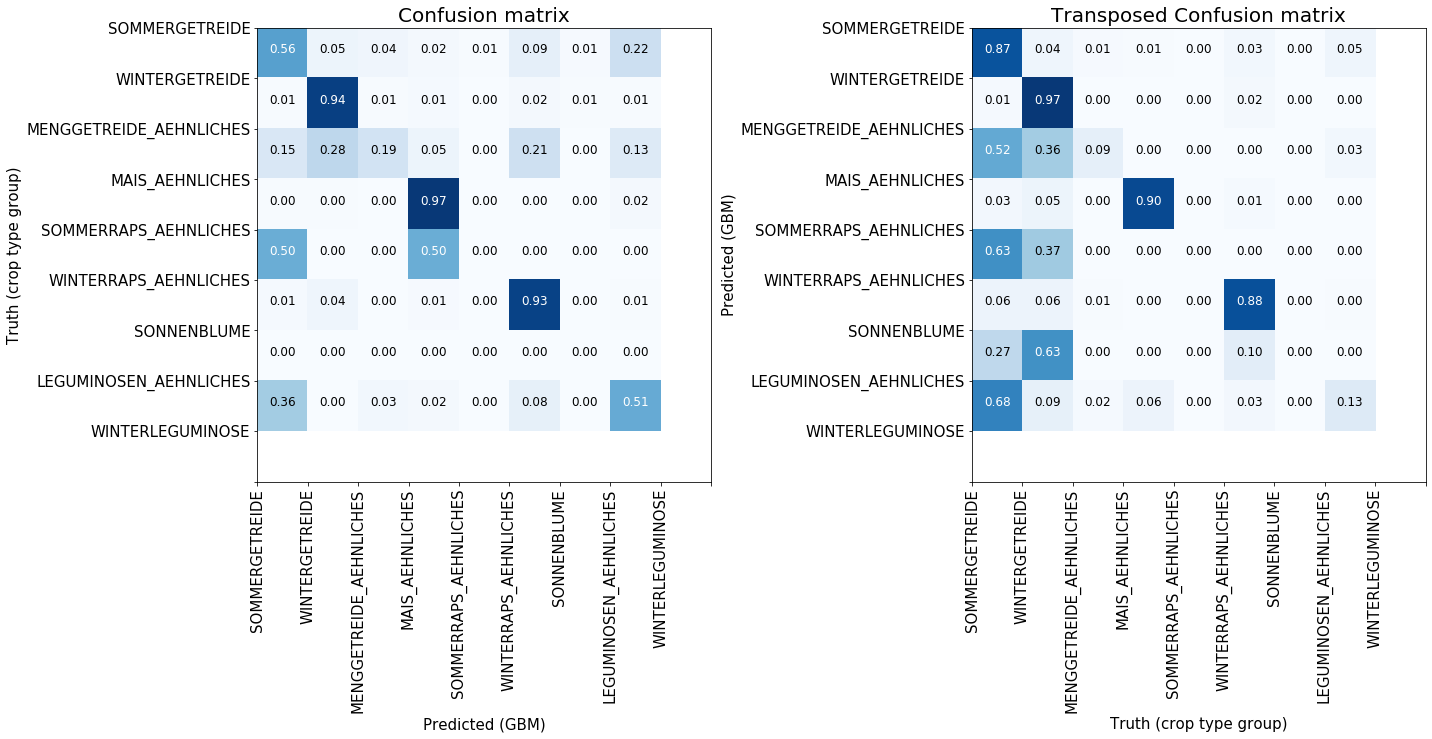

In [32]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (crop type group)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (crop type group)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

Text(0, 0.5, 'Area [ha] ')

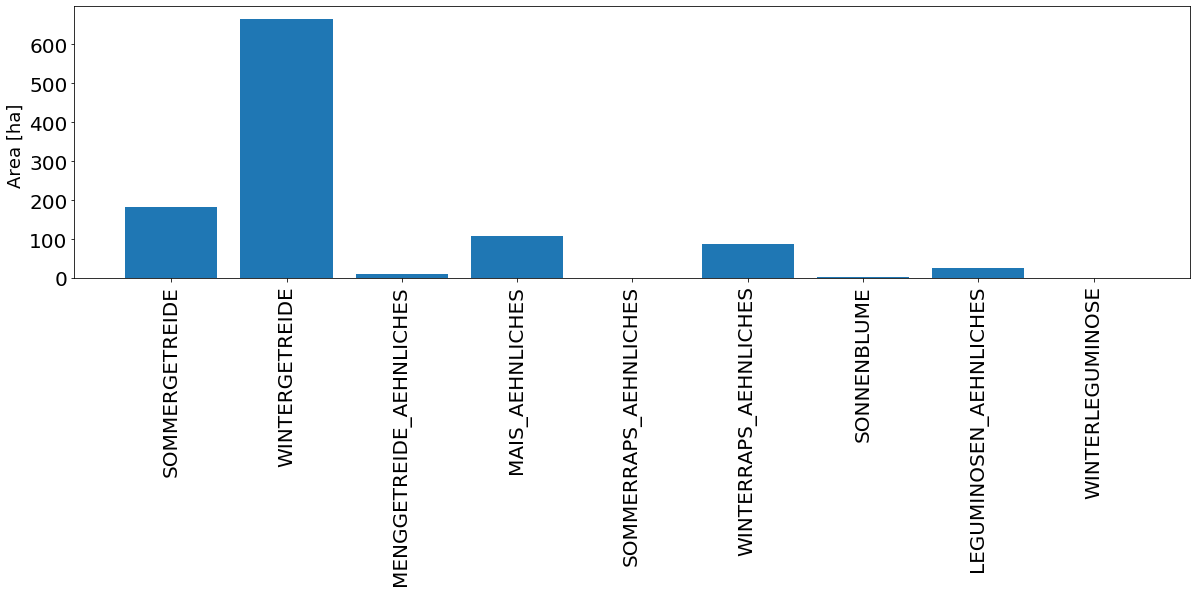

In [33]:
fig = plt.figure(figsize=(20, 5))
label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts/100)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=90, fontsize=20);
plt.yticks(fontsize=20);
plt.ylabel("Area [ha] ", size=18)

### Predict Crop Type

In [34]:
# Define Tasks

class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, t * f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]

        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return eopatch

class MaskNoDataInPrediction(EOTask):
    """
    Mask No Data in prediction
    """
    
    def __init__(self, src_layer, no_data_value, predicted_labels_name):
        self.src_layer = src_layer
        self.no_data_value = no_data_value
        self.predicted_labels_name = predicted_labels_name
    
    def execute(self, eopatch):
        NO_DATA = eopatch.mask_timeless[self.src_layer] == self.no_data_value
        eopatch.mask_timeless[self.predicted_labels_name][NO_DATA] = self.no_data_value
        
        return eopatch

In [35]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadTask(path_out_sampled)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# Mask No Data in Prediction
mask_no_data = MaskNoDataInPrediction("CROP_TYPE", 0, "LBL_GBM")

# TASK FOR SAVING
save = SaveTask(str(path_out_sampled), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
tiff_location = './predicted_tiff'
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow = LinearWorkflow(
    load,
    predict,
    mask_no_data,
    export_tiff,
    save
)

In [36]:
# create a list of execution arguments for each patch
execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            export_tiff: {'filename': '{}/prediction_eopatch_{}_original.tiff'.format(tiff_location, i)},
            save: {'eopatch_folder': 'eopatch_{}'.format(i)}
        }
    )

# run the executor on 2 cores
executor = EOExecutor(workflow, execution_args)

# uncomment below save the logs in the current directory and produce a report!
#executor = EOExecutor(workflow, execution_args, save_logs=True)

executor.run(workers=1, multiprocess=False)
executor.make_report()

## Part 3: Visualize the prediction

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


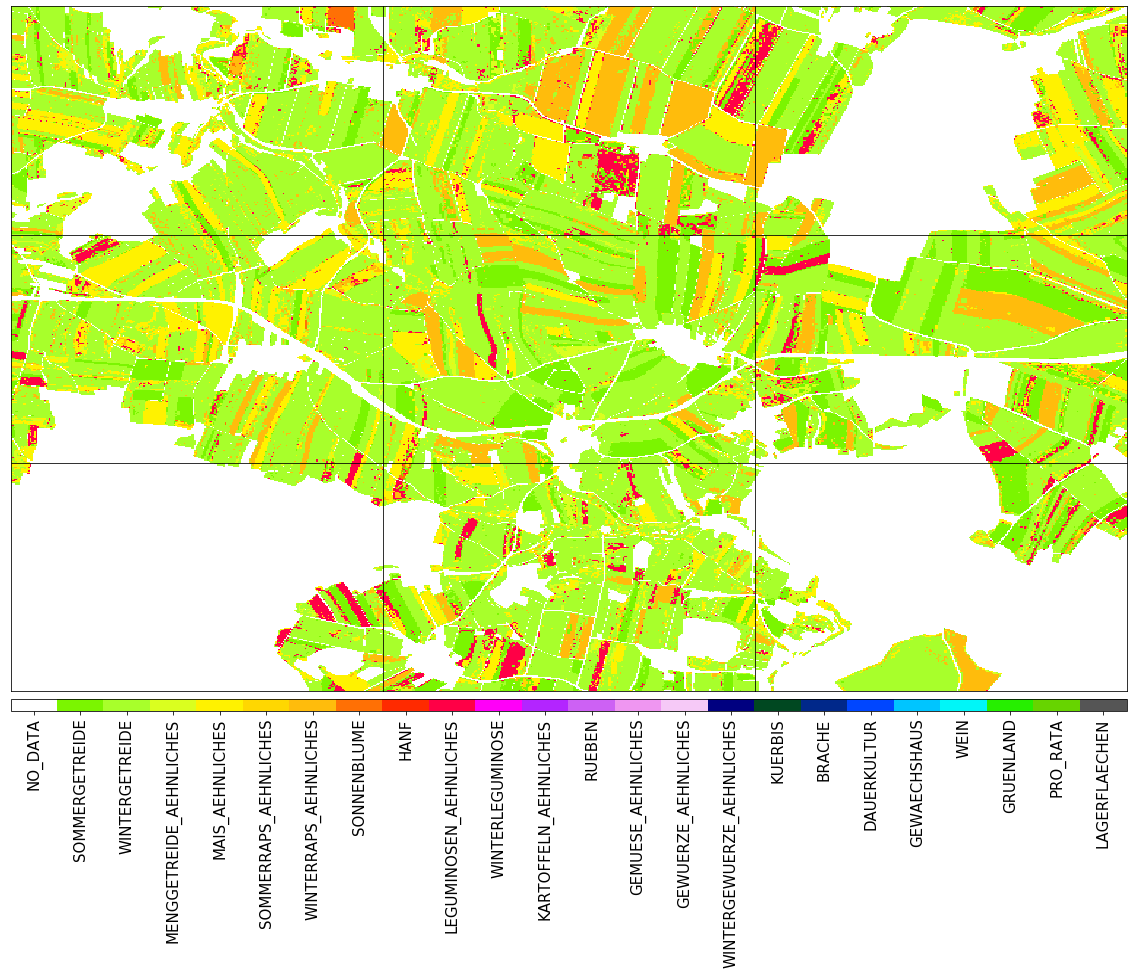

In [37]:
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze(), cmap=ct_cmap, norm=ct_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in CTGROUPS])
cb.ax.set_xticklabels([entry.class_name for entry in CTGROUPS], rotation=90, fontsize=15)
plt.show()

### Visual inspection of patches

Here is just a simple piece of code that allows a closer inspection of the predicted labels. 

Random subsets of patches are chosen, where prediction and ground truth are compared. For visual aid the mask of differences and the true color image are also provided.

In majority of the cases, differences seem to lie on the border of different structures.

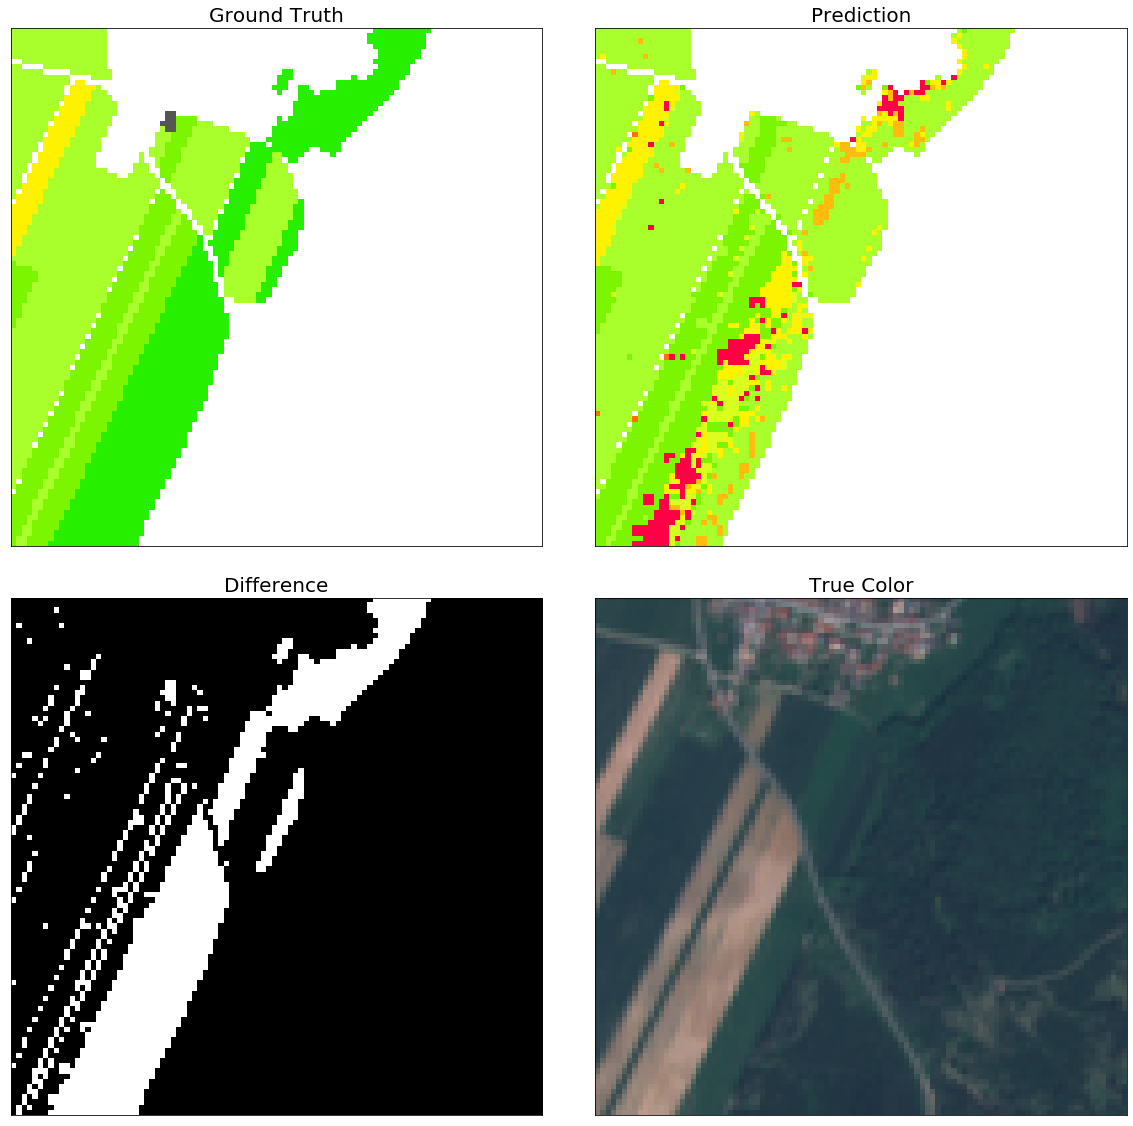

In [38]:
# Draw the Reference map

fig = plt.figure(figsize=(20, 20))
idx = np.random.choice(range(9))
inspect_size = 100

eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, idx), lazy_loading=True)

w, h = eopatch.mask_timeless['CROP_TYPE'].squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
h_min = np.random.choice(range(h - inspect_size))

ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless['CROP_TYPE'].squeeze()[w_min: w_min + inspect_size, h_min : h_min + inspect_size],
           cmap=ct_cmap, norm=ct_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze()[w_min: w_min + inspect_size, h_min: h_min + inspect_size],
           cmap=ct_cmap, norm=ct_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless['LBL_GBM'].squeeze() != eopatch.mask_timeless['CROP_TYPE'].squeeze()
plt.imshow(mask[w_min: w_min + inspect_size, h_min: h_min + inspect_size], cmap='gray')
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('Difference', fontsize=20)

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data['FEATURES'][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min: w_min + inspect_size, h_min: h_min + inspect_size])
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('True Color', fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

## Part 4: Classification per LPIS ID

Here classification for a specific parcel identified with the unique ID from the OGD Dataset can be carried out.

LPIS reference dates and time intervall for satellite imagery have to correspond to the timestamps used for classification.


In [39]:
# Specify OGD ID

lpis_id = 126939

model_path = './model_AT_CT_smaller.pkl'
model = joblib.load(model_path)


# LPIS reference date
dateFilterMin = '2018-06-30'
dateFilterMax = '2018-06-30'

# Satellite imagery time series
selected_date_interval_for_satellite_imagery = ['2018-01-01', '2018-09-30']

target_crs = CRS.UTM_33N.epsg
tableName = "lpis_at"

### Load Parcel

In [40]:
def lpis_geom_by_id(tableName, lpis_id, target_crs, dateFilterMin, dateFilterMax):

    with psycopg2.connect(**db_conn_params) as db_conn:
        sql = '''
            SELECT 
                ctnuml4a, 
                ST_Transform(geometry, {targetCrs}) as geometry
            FROM {tableName}
            WHERE 
                ogd_id = {lpis_id}
            AND 
                ref_date >= '{dateFilterMin}' 
            AND ref_date <= '{dateFilterMax}'
            '''

        sql = sql.format(tableName = tableName, 
                         targetCrs = target_crs,
                         lpis_id = lpis_id,
                         dateFilterMin = dateFilterMin, 
                         dateFilterMax = dateFilterMax)
        return gpd.GeoDataFrame.from_postgis(sql, db_conn, geom_col='geometry')

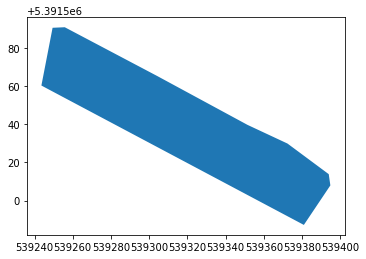

In [41]:
# load parcel
lpis_df = lpis_geom_by_id(tableName, lpis_id, target_crs, dateFilterMin, dateFilterMax)

# remap ids
lpis_df["ct"] = lpis_df["ctnuml4a"].apply(lambda x: ctnuml4aToctMapping[x])

# Visualize the parcel shape
lpis_df.plot()

### Define workflow

Workflow for classifiaction of the single parcel:

In [42]:
path_out = './eopatches_lpis'

if not os.path.isdir(path_out):
    os.makedirs(path_out)

bbox = BBox(lpis_df.iloc[0].geometry.bounds, crs=target_crs)    
add_parcel = AddFeature((FeatureType.VECTOR_TIMELESS, "CROP_TYPE_GDF"))
mask_no_data = MaskNoDataInPrediction("CROP_TYPE_ERODED", 0, "LBL_GBM")
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'CROP_TYPE','CROP_TYPE_ERODED'), disk_radius=1)
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    add_parcel,
    ct_rasterization_task,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    predict,
    mask_no_data,
    save
)

### Execute workflow

In [43]:
%%time

execution_args = []

execution_args.append({
    add_data: {'bbox': bbox, 'time_interval': selected_date_interval_for_satellite_imagery},
    add_parcel: {'data': lpis_df},
    save: {'eopatch_folder': 'eopatch_{}'.format(lpis_id)}
})
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=True)

executor.make_report()


CPU times: user 1.58 s, sys: 160 ms, total: 1.74 s
Wall time: 5.15 s


### Classification Result

In [44]:
eopatch = EOPatch.load('./eopatches_lpis/eopatch_{}'.format(lpis_id))

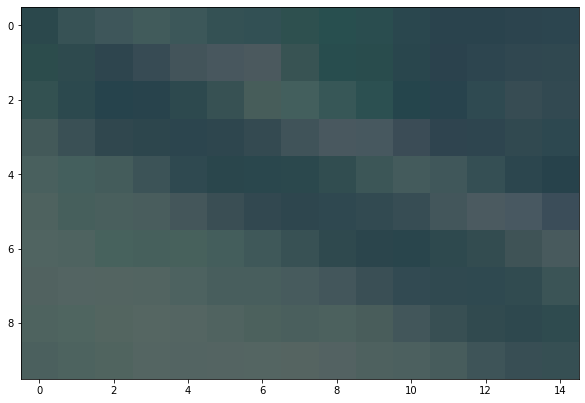

In [45]:
fig = plt.figure(figsize=(10, 10))
image = np.clip(eopatch.data['FEATURES'][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image)


#### Declaration

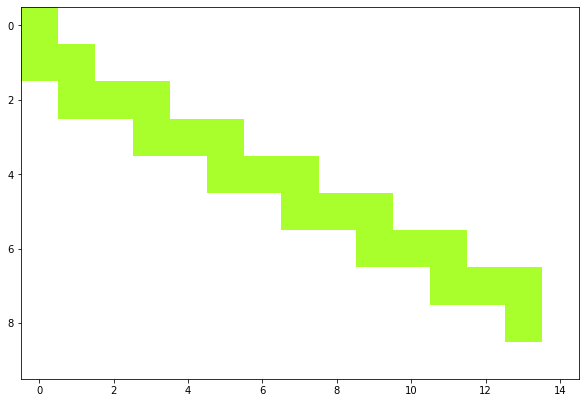

In [46]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(eopatch.mask_timeless['CROP_TYPE_ERODED'].squeeze(), cmap=ct_cmap, norm=ct_norm)

#### Prediction

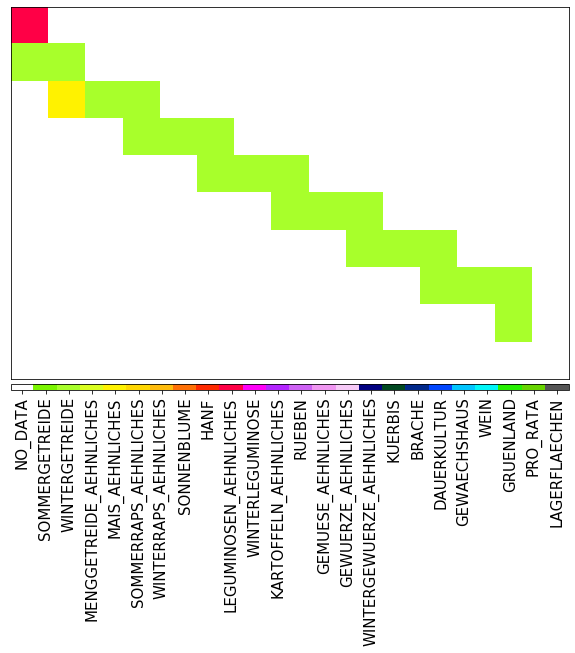

In [47]:
fig = plt.figure(figsize=(10, 10))
axes = plt.gca()


im = plt.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze(), cmap=ct_cmap, norm=ct_norm)
plt.xticks([])
plt.yticks([])


cb = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in CTGROUPS])
cb.ax.set_xticklabels([entry.class_name for entry in CTGROUPS], rotation=90, fontsize=15)
plt.show()

#### Accuracy of classification

In [48]:
mask = (eopatch.mask_timeless['CROP_TYPE_ERODED'] != 0).squeeze()

REF = eopatch.mask_timeless['CROP_TYPE'].squeeze()[mask]
LBL_GBM = eopatch.mask_timeless['LBL_GBM'].squeeze()[mask]

# classification is class with most pixels
unique = np.unique(LBL_GBM, return_counts=True)
classification_id = unique[0][unique[1].argmax()]

# remap to original id
classification_id_mapped = ctToctnuml4aMapping[classification_id][0]

# precentage of pixels in prediction classified same as lpis
accuracy = sum(REF == LBL_GBM) / len(LBL_GBM)

print("Parcel with ID {} classified as class {} with an accuracy of {:.2%}".format(lpis_id, classification_id_mapped, accuracy))


Parcel with ID 126939 classified as class 1020 with an accuracy of 90.91%


## Part 5: Persist classification results in database

### Add the model configuration to the db

In [49]:
model_name = "default_3x3_noe"

model_config = {

  "reference": {
      "table": "lpis_at",
      "column": "ctnuml4a",
      
  },
    
  "classifiier": "lgbm",
    
  "model_parameters":
    {
      "boosting_type": "gbdt",
      "num_leaves": 31, 
      "max_depth": -1, 
      "learning_rate": 0.1
    },
    
  "valid_data_threshold": 0.8,
    
  "interpolation_range": {
    "start": "2018-01-01",
    "end": "2018-09-30",
    "interval": 16
  },
    
  "erosion_radius": 1,
    
  "features": 
  [
    "B02",
    "B03",
    "B04",
    "B08",
    "B11",
    "B12",
    "NDVI",
    "NDWI",
    "NORM"
  ],
    
  "training_bounds": bounds
}

In [50]:
insert_model = """
INSERT INTO model_at (name, ref_date, training_time, configuration)
VALUES (
    '{model_name}', 
    '2018-06-30', 
        (
            SELECT CURRENT_TIMESTAMP
        ),
    '{config}'
        
    ); 
""".format(
    config = str(model_config).replace("'", "\""),
    model_name = model_name
)

with psycopg2.connect(**db_conn_params) as db_conn:
    with db_conn.cursor() as cur:
        cur.execute(insert_model)
        db_conn.commit()

### Add all classification results for parcels within definded bounds

In [51]:
# change this bounding box depending on where the classification should be carried out
bounds_for_classification = bounds
model_name = "default_3x3_noe"

#### EOTasks

In [52]:
class AddPredictionToDatabase(EOTask):
    def __init__(self, ref_date, model_id, target_table, db_conn_params):
        self.ref_date = ref_date
        self.model_id = model_id
        self.target_table = target_table
        self.db_conn_params = db_conn_params

        
    def execute(self, eopatch, parcel_id):
        
        mask = (eopatch.mask_timeless['CROP_TYPE_ERODED'] != 0).squeeze()

        # scores per pixel
        scores_pixel = eopatch.data_timeless["SCR_GBM"][mask]

        # averaged scores for each class form pixels to parcel
        scores_parcel = np.nanmean(scores_pixel, axis=0)

        # ranking
        ranking = np.argsort(scores_parcel)

        # probabilities ordered descending by ranking
        scores_parcel = scores_parcel[ranking][::-1]

        # ranked classes ordered descending by ranking
        classes_parcel = model.classes_[ranking[::-1]]

        # mapped back to original
        classes_parcel_original = np.vectorize(lambda x: ctToctnuml4aMapping[x][0])(classes_parcel)
        
        prediction = [
            dict(
                crop_id=crop_id, 
                probability=round(probability, 2) if not np.isnan(probability) else 0
            )

            for crop_id, probability in zip(classes_parcel_original, scores_parcel)
        ]
        
        
        sql = """
        INSERT INTO {target_table} (parcel_id, ref_date, model_id, prediction)
        VALUES (
             {parcel_id}, 
            '{ref_date}', 
             {model_id},
            '{prediction}'
            )
            
        -- skip existing entries
        ON CONFLICT DO NOTHING 
        ; 
        """

        sql = sql.format(
            target_table = self.target_table,
            parcel_id = parcel_id,
            ref_date = self.ref_date,
            model_id = self.model_id,
            prediction = str(prediction).replace("'", "\"")
        )
        with psycopg2.connect(**self.db_conn_params) as db_conn:
            with db_conn.cursor() as cur:
                cur.execute(sql)
                db_conn.commit()
                
        return eopatch

#### Get Model ID

In [53]:
sql = "SELECT id from model_at where name = '{}';".format(model_name)

with psycopg2.connect(**db_conn_params) as db_conn:
    with db_conn.cursor() as cur:
        cur.execute(sql)
        model_id = cur.fetchall()[0][0]
        
print("model_id: ", model_id)

model_id:  12


#### Define workflow

In [54]:
classification_to_db = AddPredictionToDatabase('2018-06-30', model_id, 'classification_at', db_conn_params)
add_parcel = AddFeature((FeatureType.VECTOR_TIMELESS, "CROP_TYPE_GDF"))
mask_no_data = MaskNoDataInPrediction("CROP_TYPE_ERODED", 0, "LBL_GBM")
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

In [55]:
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    add_parcel,
    ct_rasterization_task,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    predict,
    mask_no_data,
    classification_to_db
)

#### List of parcels to process

In [56]:
with psycopg2.connect(**db_conn_params) as db_conn:

    sql = '''
    SELECT
        ogd_id,
        {column},
        ST_Transform(geometry, {targetCrs}) as geometry

    FROM
        {tableName}
    WHERE
        ref_date >= '{dateFilterMin}'
    AND 
        ref_date <= '{dateFilterMax}'
    AND
        ST_INTERSECTS(
            ST_Transform(geometry, 4326),
            ST_SetSRID(
                ST_MakeBox2D(
                        ST_Point({min_x}, {min_y}),
                        ST_Point({max_x}, {max_y})
                ),
                4326
            )
        );
    '''

    sql = sql.format(tableName = model_config["reference"]["table"],
                     column = model_config["reference"]["column"],
                     targetCrs = target_crs,
                     dateFilterMin = dateFilterMin, 
                     dateFilterMax = dateFilterMax,
                     min_x = bounds_for_classification[0],
                     min_y = bounds_for_classification[1],
                     max_x = bounds_for_classification[2],
                     max_y = bounds_for_classification[3],
                    )
    
    parcels_to_process = gpd.GeoDataFrame.from_postgis(sql, db_conn, geom_col='geometry', )


# remap id
parcels_to_process["ct"] = parcels_to_process["ctnuml4a"].apply(lambda x: ctnuml4aToctMapping[x])

In [57]:
parcels_to_process

,ogd_id,ctnuml4a,geometry,ct
0,333386.0,1020,"POLYGON ((538844.452 5401988.173, 538791.190 5...",2
1,333388.0,1210,"POLYGON ((538940.617 5401357.192, 538900.718 5...",21
2,334104.0,1010,"POLYGON ((538657.001 5401587.709, 538599.773 5...",1
3,334105.0,1210,"POLYGON ((539119.085 5401857.078, 539173.783 5...",21
4,334106.0,1210,"POLYGON ((538963.364 5401353.648, 538952.689 5...",21
5,513054.0,1020,"POLYGON ((538776.253 5402396.809, 538811.508 5...",2
6,511905.0,1010,"POLYGON ((538766.889 5401359.859, 539114.235 5...",1
7,512660.0,1010,"POLYGON ((539122.924 5402090.288, 539134.580 5...",1
8,1030069.0,1050,"POLYGON ((538375.922 5401676.473, 538365.054 5...",5
9,1031087.0,1210,"POLYGON ((538814.320 5401357.902, 539142.634 5...",21


#### Execute workflow

classification data is added to the database


In [58]:
execution_args = []

for i in range(len(parcels_to_process)):
    
    # Data Frame for current parcel
    parcel_df = parcels_to_process[parcels_to_process.index == i]
    parcel = parcel_df.iloc[0]
    
    bbox = BBox(parcel.geometry.bounds, crs=target_crs)    

    execution_args.append({
        add_data: {'bbox': bbox, 'time_interval': selected_date_interval_for_satellite_imagery},
        add_parcel: {'data': parcel_df},
        classification_to_db: {'parcel_id': int(parcel.ogd_id)}
    })


executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()

### Show classification results

First 20 classified parcels within the defined bounding box


In [59]:

with psycopg2.connect(**db_conn_params) as db_conn:
    with db_conn.cursor() as cur:

        sql = '''
            SELECT 
                parcel_id,
                ref_date,
                model_id,
                prediction -> 0,
                prediction -> 1,
                prediction -> 2
            FROM classification_at
            WHERE
                model_id = {model_id} AND
                ref_date = '2018-06-30'
            LIMIT 20
        '''.format(model_id=model_id)

        cur.execute(sql)
        result = cur.fetchall()

In [60]:
pd.DataFrame(result, columns=["ogd_id", "ref_date", "model_id", "1st_classification", "2nd_classification", "3rd_classification"])

,ogd_id,ref_date,model_id,1st_classification,2nd_classification,3rd_classification
0,333386,2018-06-30,12,"{'crop_id': 1020, 'probability': 0.75}","{'crop_id': 1090, 'probability': 0.13}","{'crop_id': 1010, 'probability': 0.09}"
1,333388,2018-06-30,12,"{'crop_id': 1020, 'probability': 0.69}","{'crop_id': 1060, 'probability': 0.15}","{'crop_id': 1090, 'probability': 0.06}"
2,334104,2018-06-30,12,"{'crop_id': 1090, 'probability': 0.87}","{'crop_id': 1010, 'probability': 0.11}","{'crop_id': 1040, 'probability': 0.02}"
3,334105,2018-06-30,12,"{'crop_id': 1040, 'probability': 0.41}","{'crop_id': 1020, 'probability': 0.25}","{'crop_id': 1090, 'probability': 0.2}"
4,334106,2018-06-30,12,"{'crop_id': 1060, 'probability': 0.5}","{'crop_id': 1020, 'probability': 0.39}","{'crop_id': 1090, 'probability': 0.08}"
5,513054,2018-06-30,12,"{'crop_id': 1020, 'probability': 0.98}","{'crop_id': 1060, 'probability': 0.01}","{'crop_id': 1040, 'probability': 0.01}"
6,511905,2018-06-30,12,"{'crop_id': 1100, 'probability': 0}","{'crop_id': 1090, 'probability': 0}","{'crop_id': 1070, 'probability': 0}"
7,512660,2018-06-30,12,"{'crop_id': 1090, 'probability': 0.52}","{'crop_id': 1010, 'probability': 0.43}","{'crop_id': 1020, 'probability': 0.04}"
8,1030069,2018-06-30,12,"{'crop_id': 1100, 'probability': 0}","{'crop_id': 1090, 'probability': 0}","{'crop_id': 1070, 'probability': 0}"
9,1031087,2018-06-30,12,"{'crop_id': 1090, 'probability': 0.44}","{'crop_id': 1010, 'probability': 0.36}","{'crop_id': 1040, 'probability': 0.1}"
